## Section 0 - Imports

In [1]:
# %matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from skimage.color import lab2rgb



import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

import copy
import time

from openTSNE import TSNE as opTSNE

from sklearn.mixture import GaussianMixture 


## Section Utility Functions

In [2]:
def SampleZoomIn(SampleID , PixelSampleID ,padding_factor = 1):
    specific_index = SampleID
    mask = (PixelSampleID == specific_index) 
    label_indices = np.where(mask == True)

    height , width = (PixelSampleID.shape) 

    zoomed_height_max = max(label_indices[0]) + padding_factor
    zoomed_height_min = min(label_indices[0]) - padding_factor
    zoomed_width_max = max(label_indices[1]) + padding_factor
    zoomed_width_min = min(label_indices[1]) - padding_factor

    if zoomed_height_max > height:
        zoomed_height_max= height

    if zoomed_height_min < 0:
        zoomed_height_min= 0

    if zoomed_width_max > width:
        zoomed_width_max= width

    if zoomed_width_min < 0:
        zoomed_width_min= 0
        
    return zoomed_height_max , zoomed_height_min , zoomed_width_max, zoomed_width_min



In [3]:
# Util function for convert-to (0 - 1) range
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [4]:
from matplotlib.colors import LinearSegmentedColormap
def CreateColorMap(NumberofColors , colorsArray ):
    cmap = LinearSegmentedColormap.from_list('cmap', colorsArray, N=NumberofColors)
    return cmap

In [5]:
def CreateColorMap_Continuous(NumberofColors , colorsArray ):
    cvals = np.arange(0,NumberofColors-1)
    colors = colorsArray
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    
    return cmap

## Section 1 - Data Preparation

In [6]:
h5 = h5py.File('GastricData.mat', 'r')


# Get all data variables and store them

HE_image= h5.get('HE_image')[:]
HE_image = HE_image.swapaxes(0,2)


MSI_data_cube= h5.get('MSI_data_cube')[:]
MSI_data_cube = MSI_data_cube.swapaxes(0,2)

goodlist= h5.get('goodlist')[:]
goodlist = goodlist.swapaxes(0,1)

peak_list= h5.get('peak_list')[:]
peak_list = peak_list.swapaxes(0,1)

pixel_to_sample_ID= h5.get('pixel_to_sample_ID')[:]
pixel_to_sample_ID = pixel_to_sample_ID.swapaxes(0,1)  

h5.close()

# Clinical_data = pd.read_excel('ClinicalData.xlsx')

height , width = (pixel_to_sample_ID.shape) # ( 443 , 1653 )

flattened_MSI_data_cube = MSI_data_cube.flatten().reshape(MSI_data_cube.shape[0] * MSI_data_cube.shape[1] , MSI_data_cube.shape[2])

flattened_pixel_to_sample_ID = pixel_to_sample_ID.flatten() 
indices_of_background = np.where(flattened_pixel_to_sample_ID == -1)
sample_only_data = np.delete(flattened_MSI_data_cube, indices_of_background[0] , axis=0)
sample_ID_pixels = np.delete(flattened_pixel_to_sample_ID , indices_of_background[0] , axis=0)
# The scaler object (model)
scaler = StandardScaler()
# fit and transform the data
sample_only_scaled_data = scaler.fit_transform(sample_only_data) 

## Section 2 - PCA

In [7]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(sample_only_scaled_data)

pca_df = pd.DataFrame(data=pca_result[:],columns=["PC1","PC2","PC3","PC4","PC5"])
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_

Explained variation per PC: [0.18299616 0.09497918 0.06341938 0.04655058 0.03732335]


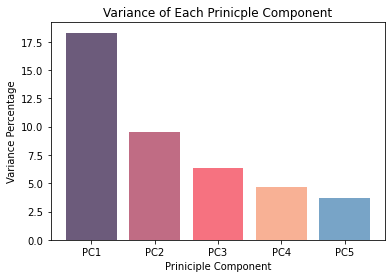

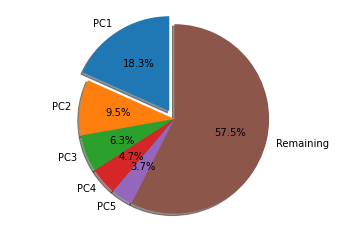

Variance Represented by PCA = 42.53 %


In [8]:
PCA=["PC1","PC2","PC3","PC4","PC5"]

COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195", "#78a4c7"]

plt.bar(PCA, variance*100, color=COLORS)

plt.title('Variance of Each Prinicple Component')
plt.xlabel('Priniciple Component')
plt.ylabel('Variance Percentage')

# Pie chart
labels = 'PC1', 'PC2', 'PC3', 'PC4' , 'PC5' , 'Remaining'
sizes = [ variance[0], variance[1], variance[2], variance[3] , variance[4] , 1 - ( variance[0] + variance[1] + variance[2] + variance[3] + variance[4] )  ]
explode = (0.1, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Variance Represented by PCA = ' + str(round((variance[0] + variance[1] + variance[2] + variance[3] + variance[4])*100 , 2) ) +' %')

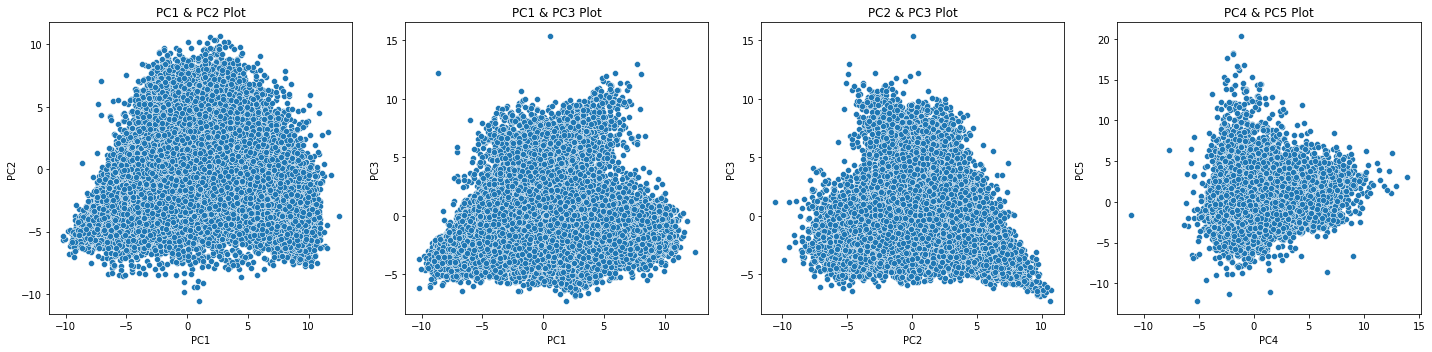

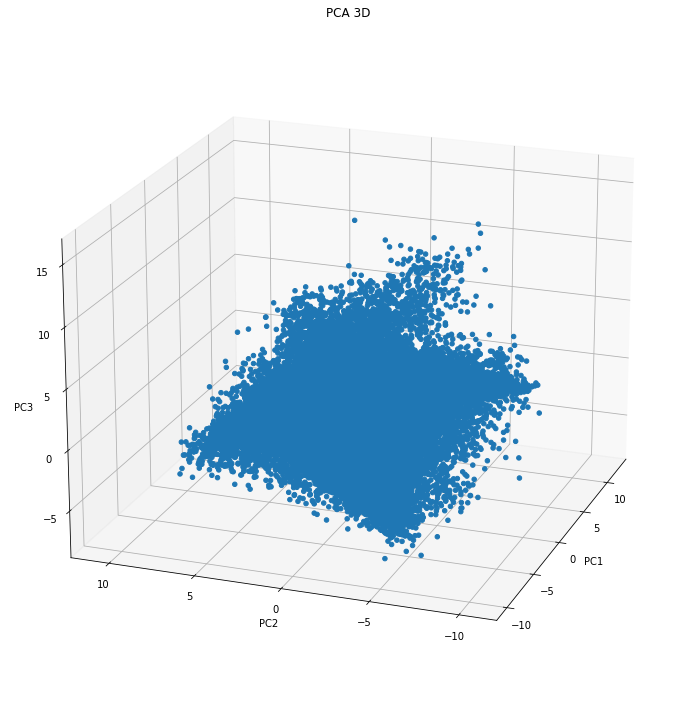

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(
    ax=axes[0],
    x="PC1", y="PC2",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[0].set_title("PC1 & PC2 Plot")

sns.scatterplot(
    ax=axes[1],
    x="PC1", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[1].set_title("PC1 & PC3 Plot")

sns.scatterplot(
    ax=axes[2],
    x="PC2", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[2].set_title("PC2 & PC3 Plot")

sns.scatterplot(
    ax=axes[3],
    x="PC4", y="PC5",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[3].set_title("PC4 & PC5 Plot")

plt.tight_layout()
plt.show()



ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=pca_df['PC1'], 
    ys=pca_df['PC2'], 
    zs=pca_df['PC3'], 
    alpha = 1
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA 3D")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()
plt.show()


## Section 3 - tSNE

In [10]:
# tSNE Model , Run once and save results in numpy array to be used later

'''
time_start = time.time()
op_tsne_results = TSNE(n_components=3,
            perplexity = 50,
            learning_rate = 200,
            init = 'random',
            random_state = 0,
            early_exaggeration = 12,
            n_iter = 1000,
            verbose=True,
            ).fit_transform(sample_only_scaled_data)


print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

"\ntime_start = time.time()\nop_tsne_results = TSNE(n_components=3,\n            perplexity = 50,\n            learning_rate = 200,\n            init = 'random',\n            random_state = 0,\n            early_exaggeration = 12,\n            n_iter = 1000,\n            verbose=True,\n            ).fit_transform(sample_only_scaled_data)\n\n\nprint('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))\n"

In [11]:
# np.save('tSNE_Results_default_' + 'Time_{}_seconds'.format(time.time()-time_start) , op_tsne_results)

In [12]:
# Load the t-SNE results
# op_tsne_results = np.load('op_tSNE_Results_Time_456.8306334018707_seconds.npy')
op_tsne_results = np.load('tSNE_Gastric_Results_default_Time_5587.012503623962_seconds.npy')

In [13]:
# Creating tSNE Dataframe with L,A,B Components interpreted from tSNE Dimensions
tsne_df = pd.DataFrame(data=op_tsne_results[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = sample_ID_pixels
tsne_df['L_Component'] = op_tsne_results[:,0]
tsne_df['A_Component'] = op_tsne_results[:,1]
tsne_df['B_Component'] = op_tsne_results[:,2]

In [14]:
# Converting tSNE dimensions to be represented 

LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A , B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)


C:\Users\dell\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1742 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


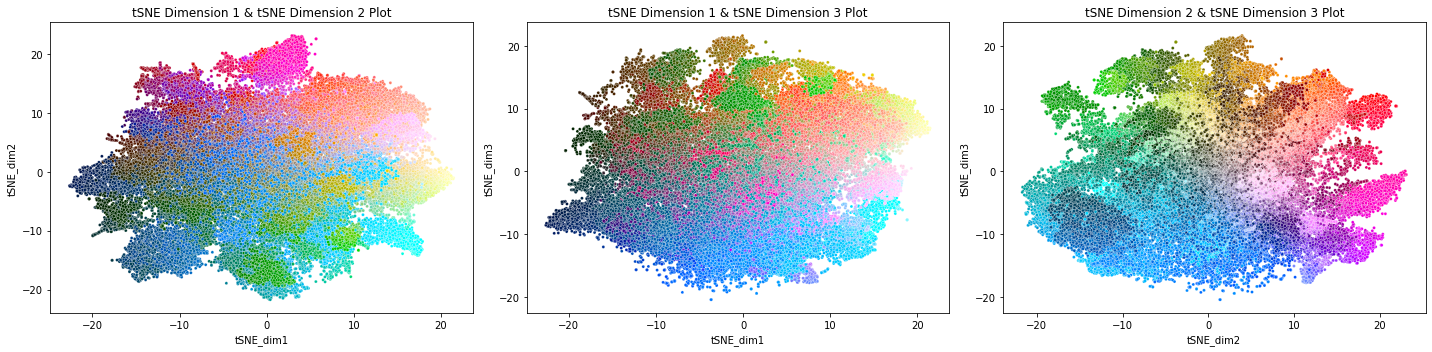

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()



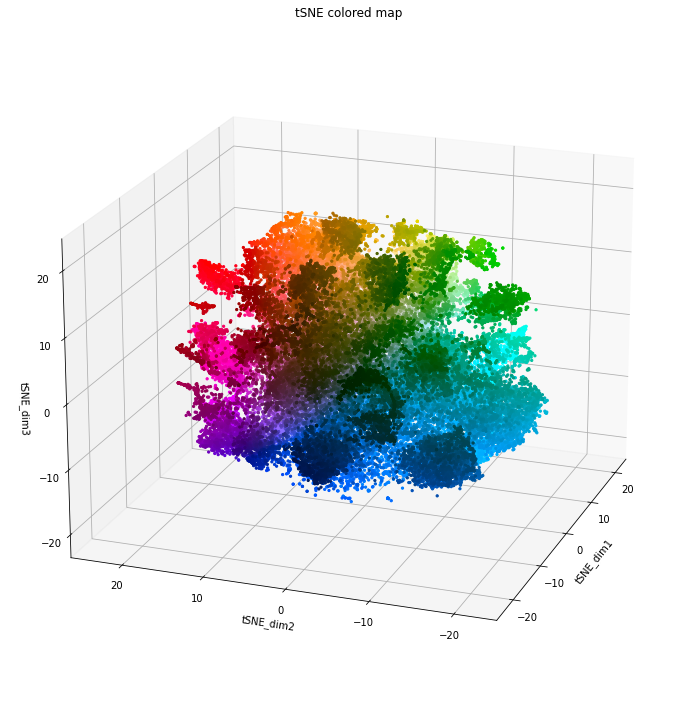

In [16]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = RGB_colors,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE colored map")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


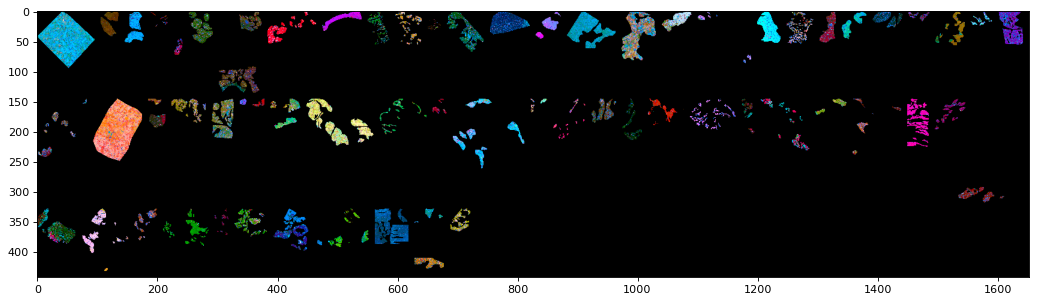

In [17]:
indices_edit = np.where(pixel_to_sample_ID != -1)
tsne_image = np.zeros( (height,width,3) )
increment = 0

for i,j in zip(indices_edit[0],indices_edit[1]):
    tsne_image[i][j][0] = RGB_colors[increment][0]
    tsne_image[i][j][1] = RGB_colors[increment][1]
    tsne_image[i][j][2] = RGB_colors[increment][2]
    increment += 1

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(tsne_image)


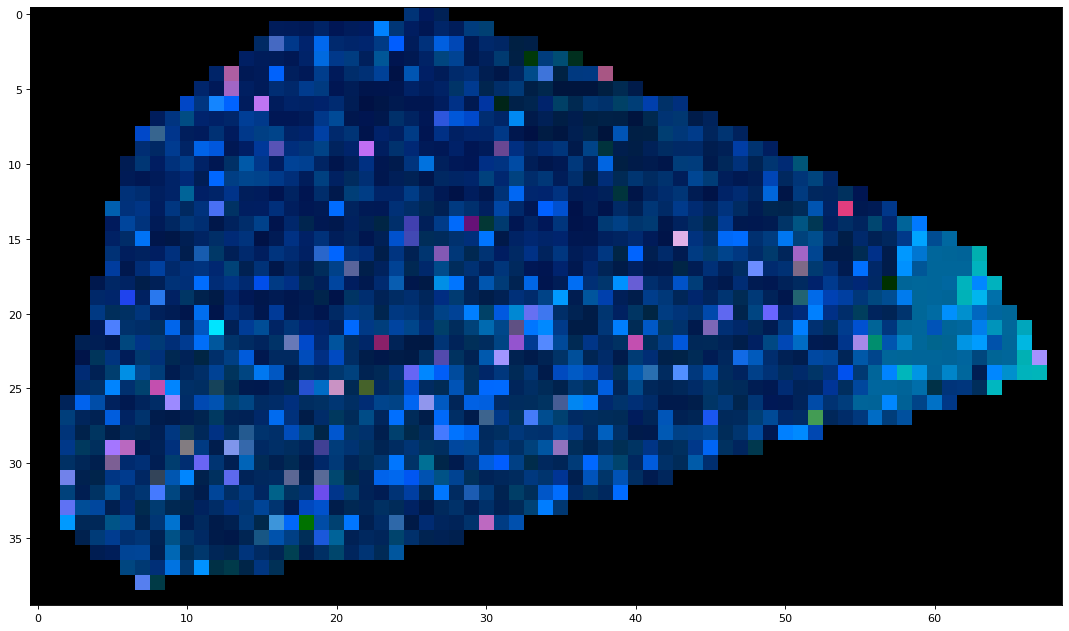

In [18]:
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
tsne_zoomed_in_image = tsne_image[zoomed_height_min : zoomed_height_max, zoomed_width_min : zoomed_width_max]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(tsne_zoomed_in_image)

plt.tight_layout()

## Section 4 - Kmeans

In [19]:
############# Sklearn K-mean #################
kmeans_3 = KMeans(n_clusters=3, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(op_tsne_results)
kmeans_4 = KMeans(n_clusters=4, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(op_tsne_results)
kmeans_5 = KMeans(n_clusters=5, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(op_tsne_results)

In [20]:
indices_edit = np.where(pixel_to_sample_ID != -1)
KMeans_image_3 = np.full( (height,width),-1 )
KMeans_image_4 = np.full( (height,width),-1 )
KMeans_image_5 = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_3[i][j] = kmeans_3.labels_[increment]
    KMeans_image_4[i][j] = kmeans_4.labels_[increment]
    KMeans_image_5[i][j] = kmeans_5.labels_[increment]

    increment += 1

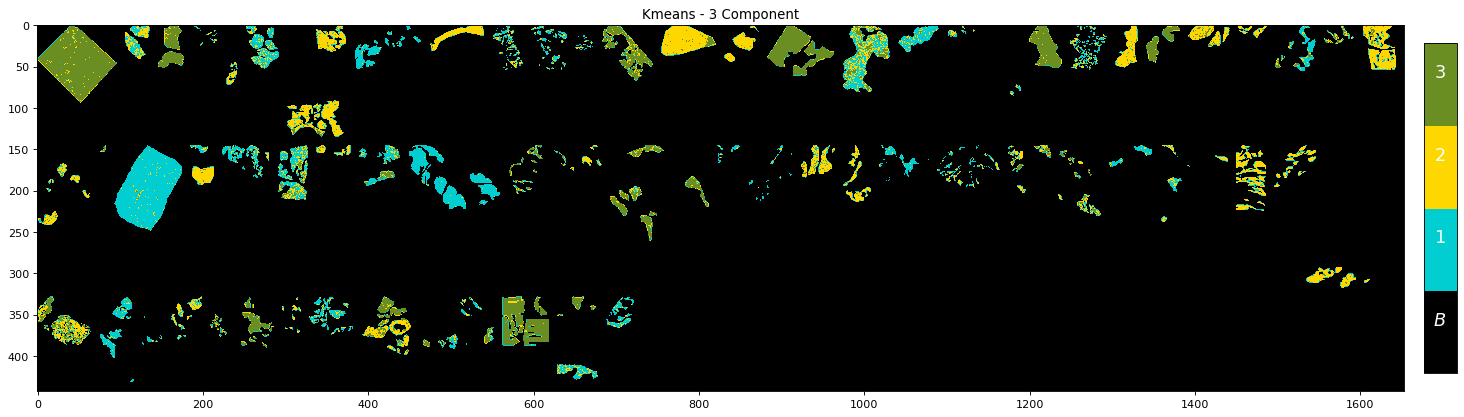

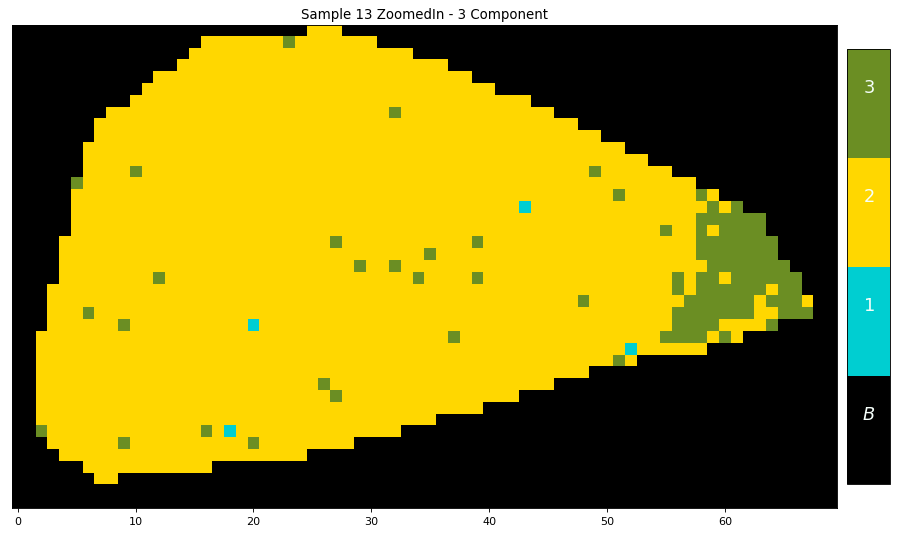

In [21]:
# 3 Components

colors = ["black","darkturquoise","gold","olivedrab"]

cmap = CreateColorMap(NumberofColors = 4 , colorsArray = colors )

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmeans - 3 Component")
plt.imshow(KMeans_image_3, cmap=cmap)
cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$']):
    cbar.ax.text(0.5, (j * 4.5 - 3.1) / 6, lab, ha='center', va='center', color="mintcream", fontsize=16, fontweight="extra bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D

plt.tight_layout()

# Zooming on sample id 13
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
kmeans_zoomedin_image = KMeans_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


plt.figure(figsize=(16, 8), dpi=80)
plt.title("Sample 13 ZoomedIn - 3 Component")
plt.imshow(kmeans_zoomedin_image, cmap=cmap)
cbar2 = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)
cbar2.ax.tick_params(size=0)
plt.yticks([])

cbar2.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$']):
    cbar2.ax.text(0.5, (j * 4.5 - 3.1) /6 , lab, ha='center', va='center', color="mintcream", fontsize=16, fontweight="extra bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D



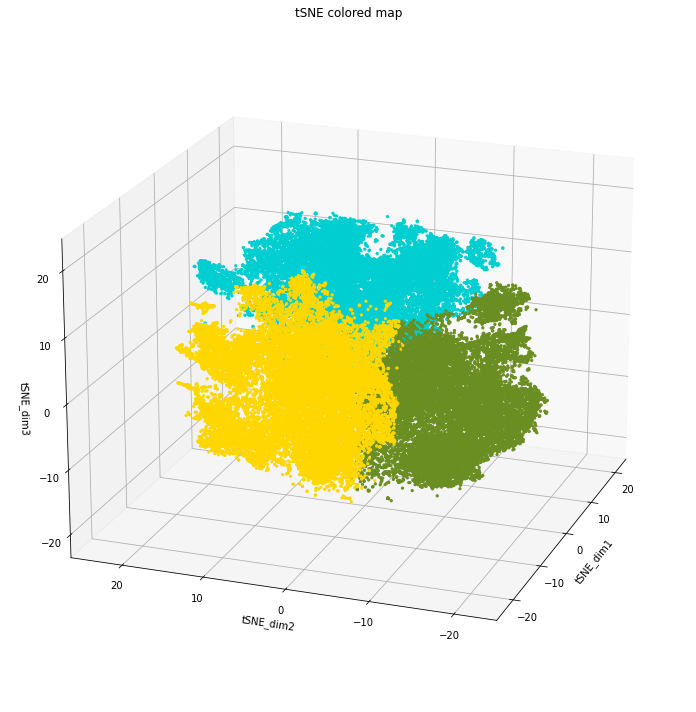

In [22]:
colors =["darkturquoise","gold","olivedrab"]
cmap = CreateColorMap(NumberofColors = 3 , colorsArray = colors )

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = kmeans_3.labels_,
    s = 5,
    cmap = cmap,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE colored map")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


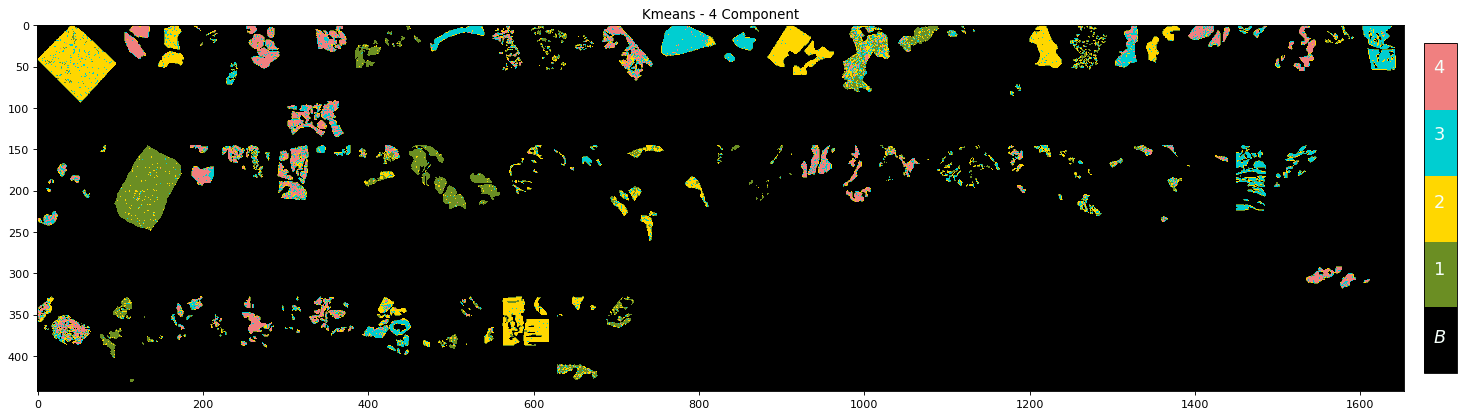

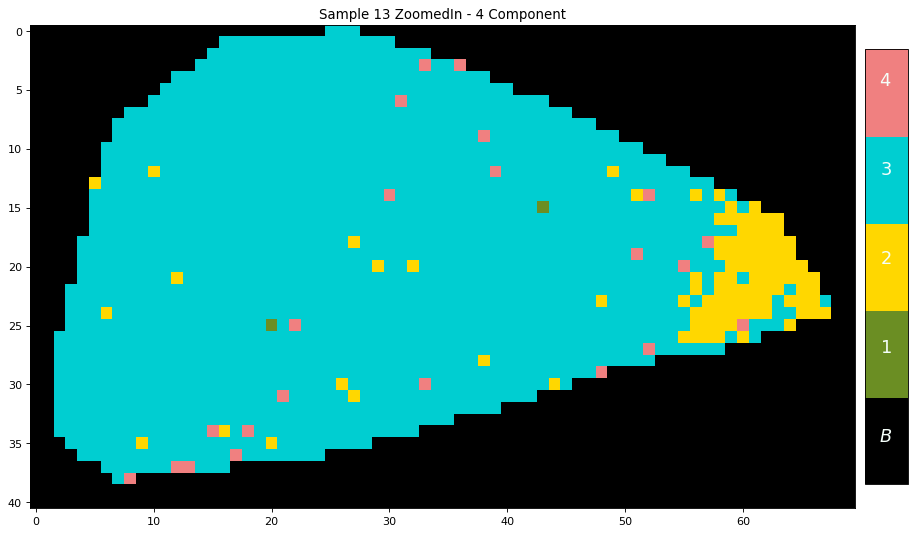

In [23]:
# 4 Components

colors = ["black","olivedrab","gold","darkturquoise", "lightcoral"]
cmap = CreateColorMap(NumberofColors = 5 , colorsArray = colors )

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmeans - 4 Component")
plt.imshow(KMeans_image_4, cmap=cmap)
cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$']):
    cbar.ax.text(0.9, (j * 4.5 - 3.1) / 5.5, lab, ha='center', va='center', color="mintcream", fontsize=16, fontweight="bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D

plt.tight_layout()

# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
kmeans_zoomedin_image = KMeans_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


plt.figure(figsize=(16, 8), dpi=80)
plt.title("Sample 13 ZoomedIn - 4 Component")
plt.imshow(kmeans_zoomedin_image, cmap=cmap)
cbar2 = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar2.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$']):
    cbar2.ax.text(0.9, (j * 4.5 - 3.1) /5.5 , lab, ha='center', va='center', color="mintcream", fontsize=16, fontweight="extra bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D


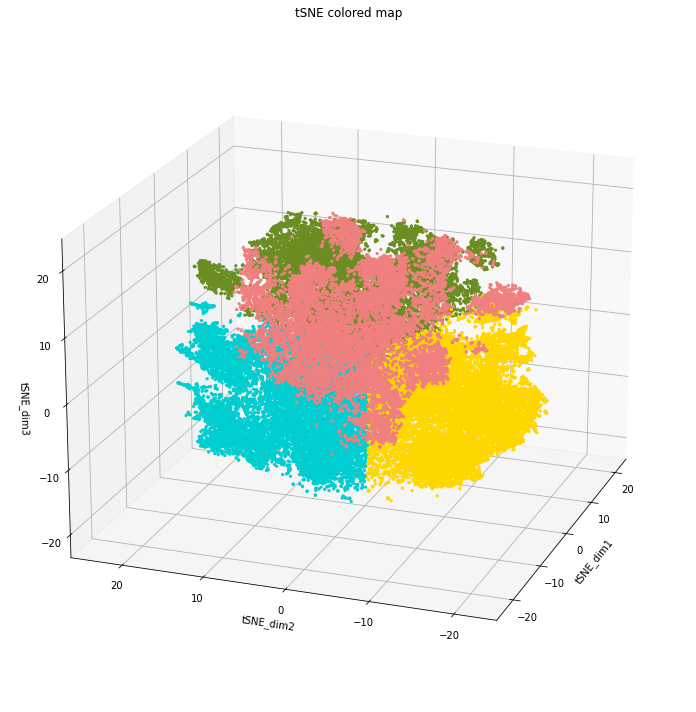

In [24]:
colors = ["olivedrab","gold","darkturquoise", "lightcoral"]
cmap = CreateColorMap(NumberofColors = 4 , colorsArray = colors )

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = kmeans_4.labels_,
    s = 5,
    cmap = cmap,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE colored map")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


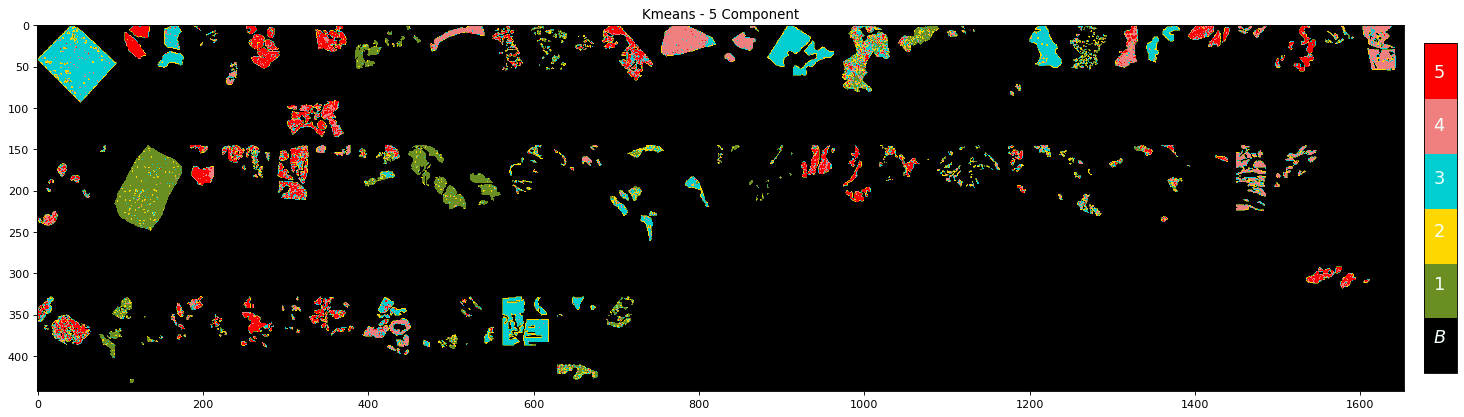

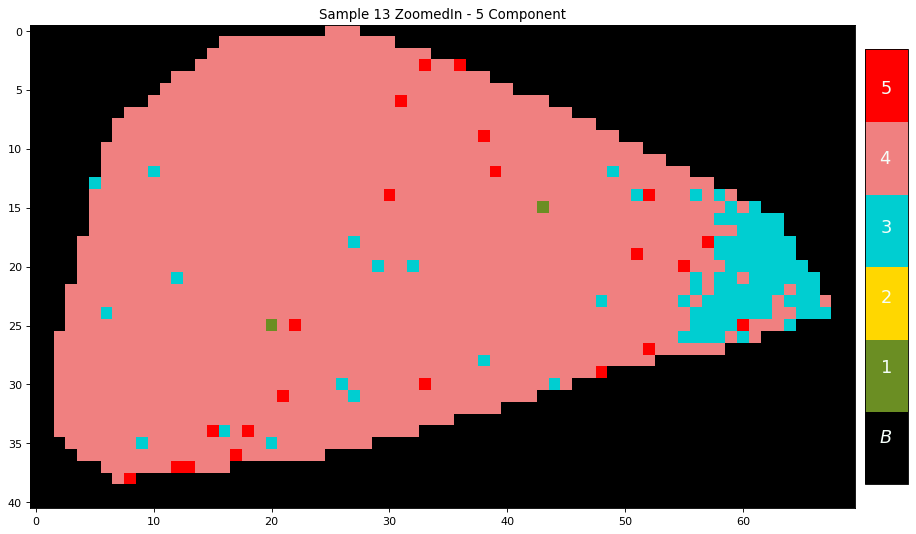

In [25]:
# 5 Components Kmeans

colors = ["black","olivedrab","gold","darkturquoise", "lightcoral","red"] 
cmap = CreateColorMap(NumberofColors = 6 , colorsArray = colors)
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmeans - 5 Component")
plt.imshow(KMeans_image_4, cmap=cmap)
cbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$']):
    cbar.ax.text(0.9, (j * 4.5 - 4) / 7, lab, ha='center', va='center', color="mintcream", fontsize=16, fontweight="bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D

plt.tight_layout()

# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
kmeans_zoomedin_image = KMeans_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


plt.figure(figsize=(16, 8), dpi=80)
plt.title("Sample 13 ZoomedIn - 5 Component")
plt.imshow(kmeans_zoomedin_image, cmap=cmap)
cbar2 = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)

cbar2.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$B$','$1$','$2$','$3$','$4$','$5$']):
    cbar2.ax.text(0.9, (j * 4.5 - 4) /7 , lab, ha='center', va='center', color="mintcream", fontsize=16, fontweight="extra bold", fontfamily="monospace" ) # the font doesn't acutally change, only the size & color :D



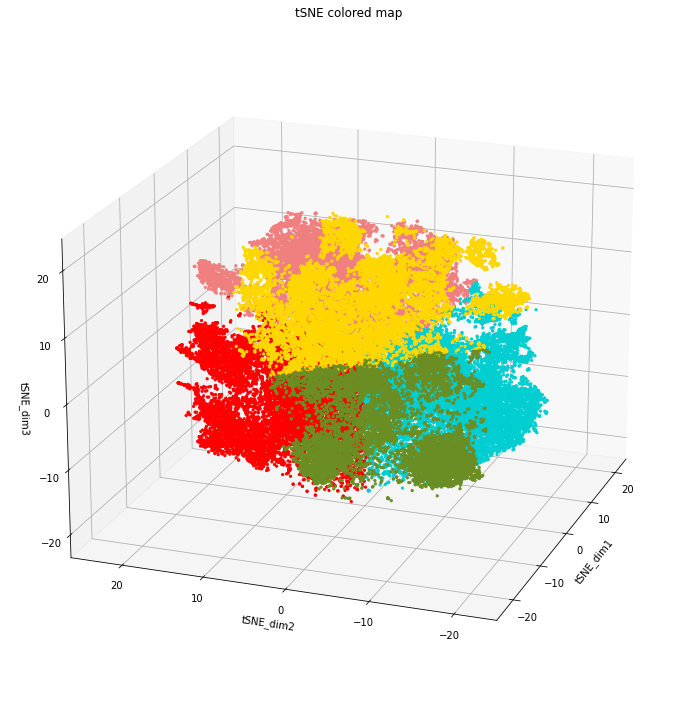

In [26]:
colors = ["olivedrab","gold","darkturquoise", "lightcoral","red"]
cmap = CreateColorMap(NumberofColors = 5, colorsArray = colors )

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = kmeans_5.labels_,
    s = 5,
    cmap = cmap,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE colored map")

ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()

## Section 5 - Gaussian Mixture


In [27]:
# Gaussian Mixture Model - Run Once


'''
gmm_3 = GaussianMixture(n_components=3, 
                         max_iter=500, 
                         n_init=100, 
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)

gmm_4 = GaussianMixture(n_components=4, 
                         max_iter=500, 
                         n_init=100, 
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)

gmm_5 = GaussianMixture(n_components=5, 
max_iter=500, 
n_init=100, 
covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)
'''





"\ngmm_3 = GaussianMixture(n_components=3, \n                         max_iter=500, \n                         n_init=100, \n                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)\n\ngmm_4 = GaussianMixture(n_components=4, \n                         max_iter=500, \n                         n_init=100, \n                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)\n\ngmm_5 = GaussianMixture(n_components=5, \nmax_iter=500, \nn_init=100, \ncovariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)\n"

In [28]:
'''
np.save("gmm_3_gastric.npy" , gmm_3)
np.save("gmm_4_gastric.npy" , gmm_4)
np.save("gmm_5_gastric.npy" , gmm_5)
'''

'\nnp.save("gmm_3_gastric.npy" , gmm_3)\nnp.save("gmm_4_gastric.npy" , gmm_4)\nnp.save("gmm_5_gastric.npy" , gmm_5)\n'

In [29]:
gmm_3 = np.load("gmm_3_gastric.npy")
gmm_4 = np.load("gmm_4_gastric.npy")
gmm_5 = np.load("gmm_5_gastric.npy")

In [30]:
indices_edit = np.where(pixel_to_sample_ID != -1)
gaussian_image_3 = np.full( (height,width),-1 )
gaussian_image_4 = np.full( (height,width),-1 )
gaussian_image_5 = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    gaussian_image_3[i][j] = gmm_3[increment]
    gaussian_image_4[i][j] = gmm_4[increment]
    gaussian_image_5[i][j] = gmm_5[increment]

    increment += 1

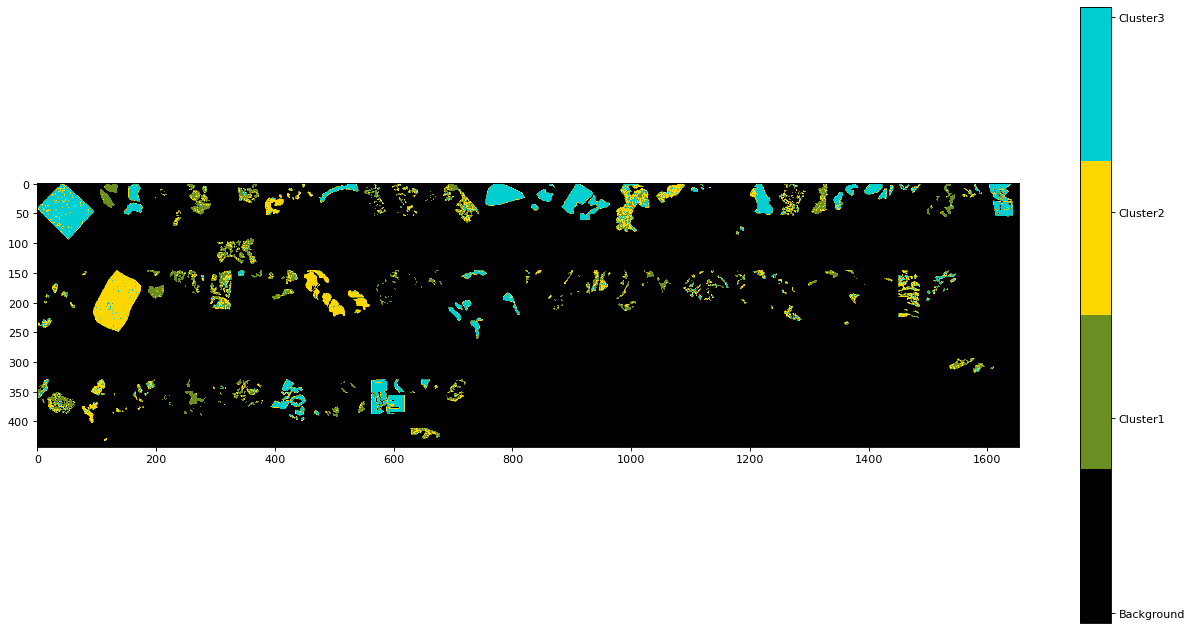

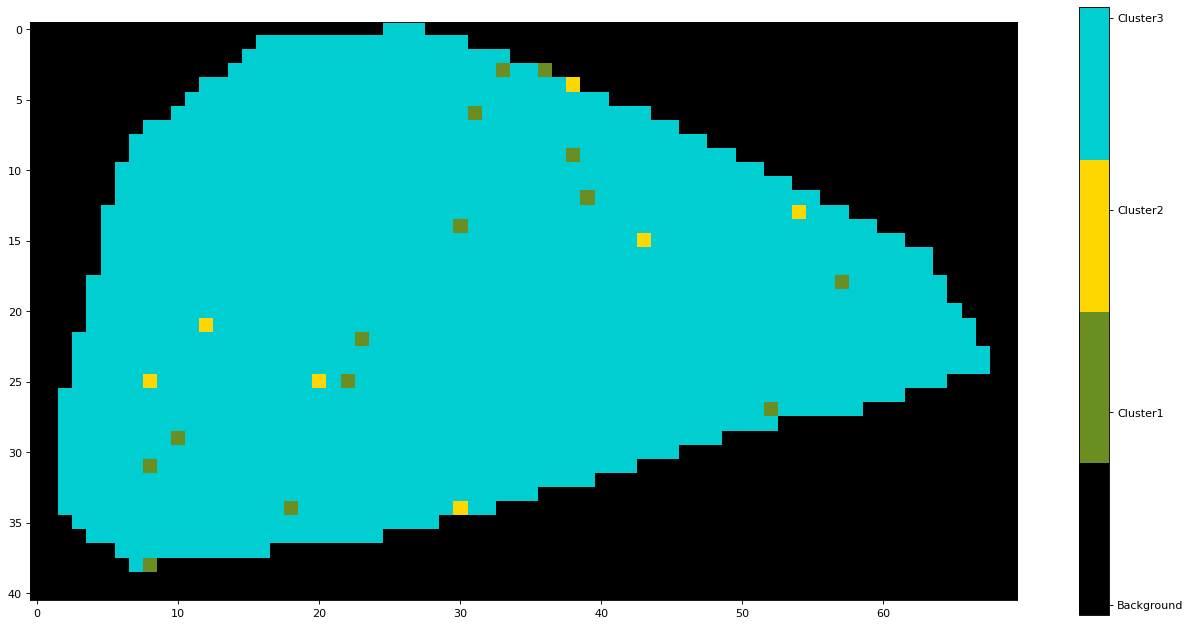

In [31]:
# 3 Components Gaussian

# Coloring the Gaussian image with specific chosen colors

colors = ["black","olivedrab","gold","darkturquoise"]
cmap = CreateColorMap(NumberofColors = 4 , colorsArray = colors )

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(gaussian_image_3, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()
# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
Gaussian_ZoomedInImage = gaussian_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(Gaussian_ZoomedInImage,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()


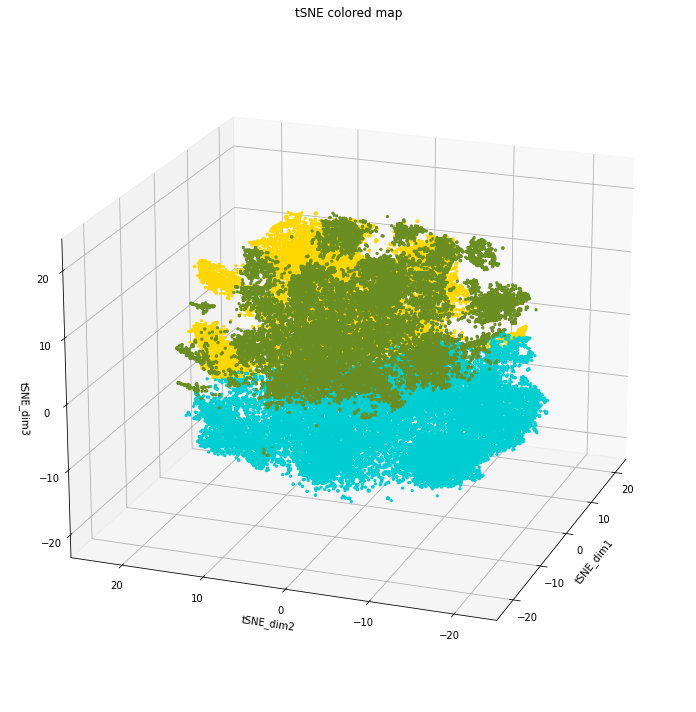

In [32]:
colors = ["olivedrab","gold","darkturquoise"]
cmap = CreateColorMap(NumberofColors = 3 , colorsArray = colors )
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = gmm_3,
    s = 5,
    cmap = cmap,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE colored map")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


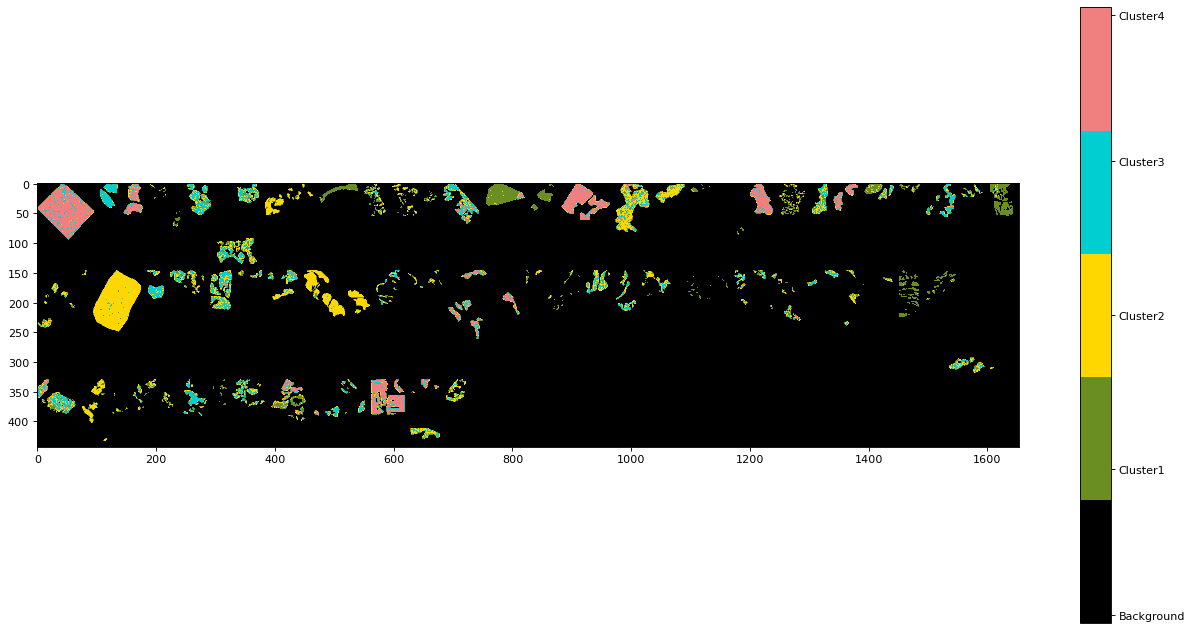

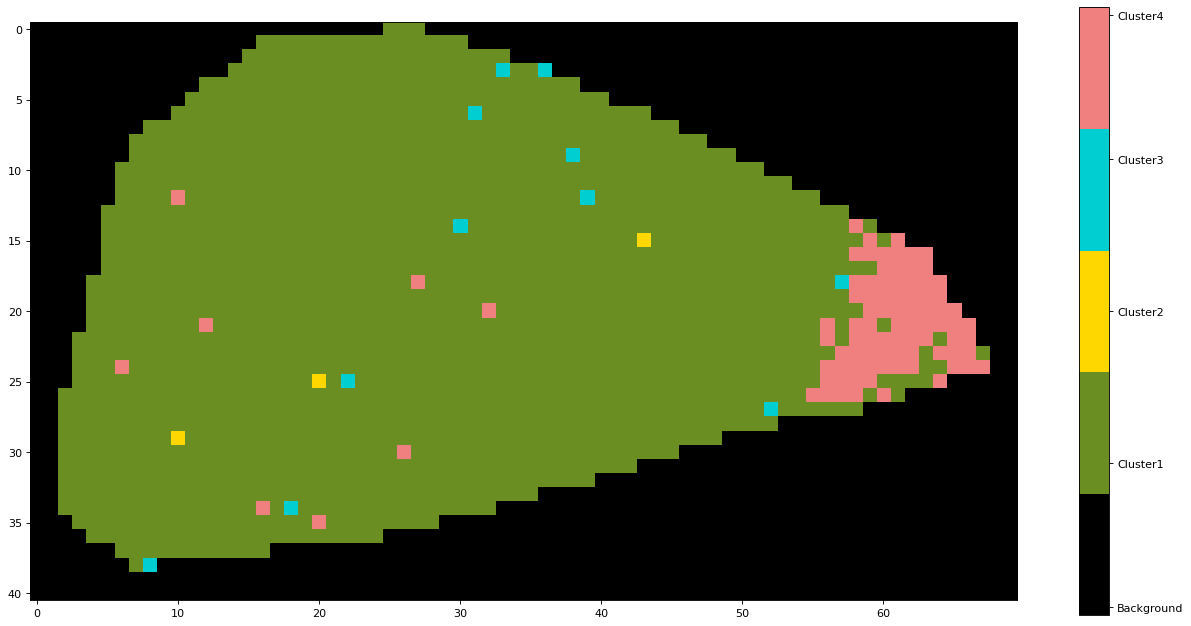

In [33]:
# 4 Components Gaussian

# Coloring the Gaussian image with specific chosen colors)

cvals = [0, 1, 2,3,4]
colors = ["black","olivedrab","gold","darkturquoise", "lightcoral"]
cmap = CreateColorMap(NumberofColors=5 , colorsArray = colors)
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(gaussian_image_4, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()
# Zooming on sample id 13

zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
Gaussian_ZoomedInImage = gaussian_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(Gaussian_ZoomedInImage,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()


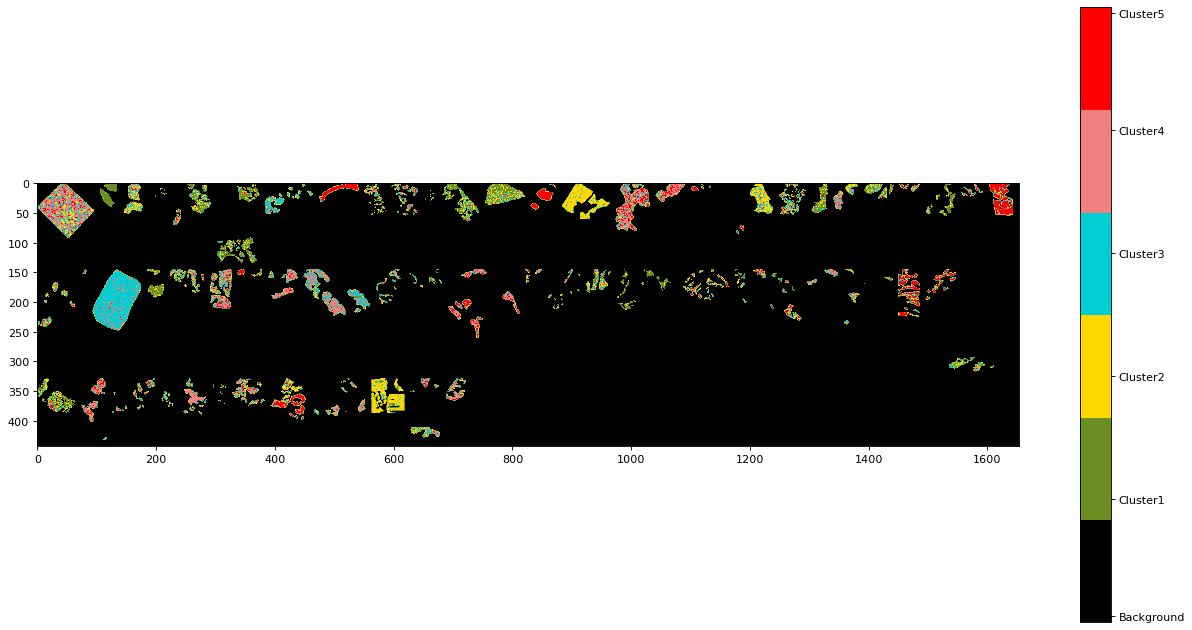

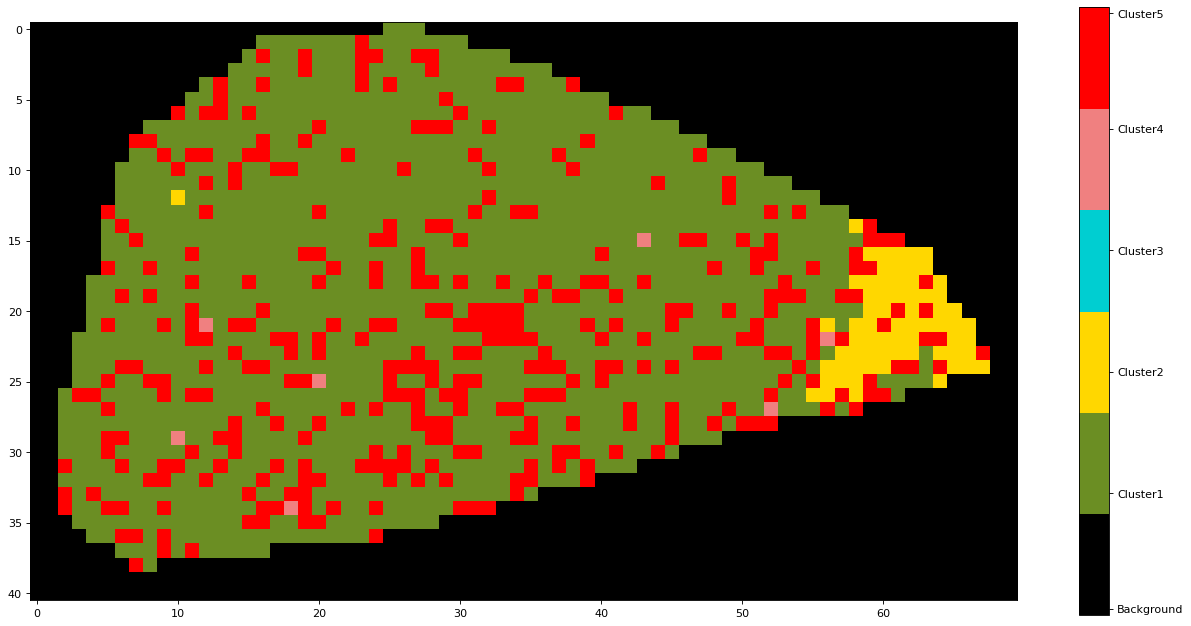

In [34]:
# 5 Components

# Coloring the Gaussian image with specific colors

cvals = [0, 1, 2,3,4,5]
colors = ["black","olivedrab","gold","darkturquoise", "lightcoral","red"] 
cmap = CreateColorMap(NumberofColors=6 , colorsArray=colors)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(gaussian_image_5, cmap=cmap)

colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
# Zooming on sample id 13
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 13 , PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
Gaussian_ZoomedInImage = gaussian_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(Gaussian_ZoomedInImage,cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()


## Kaplan Meier & Cox - Function

In [35]:
def KaplanMeierSurvivalFitter( labels , colors ,Clinical_data , sample_ID_pixels = sample_ID_pixels, SignCluster=[]):

    Clinical_data_copied = Clinical_data.copy(deep=True)
    

    labels_count = len(np.unique(labels))
    Clusters = [ [] for _ in range(labels_count) ]

    for i in range(1,len(Clinical_data)+1):
        Pixels_Samples = np.where(sample_ID_pixels == i)[0]
        Patient_Labels = labels[Pixels_Samples]

        for cluster_label in range(labels_count):
            Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]
            if len(Patient_Pixels) >= int( (1/labels_count * len(Patient_Labels))):
                Clusters[cluster_label].append(i)
    
    Belong_Clusters = [ [] for _ in range(labels_count) ]

    for i in range(1, len(Clinical_data)+1):
        for j in range(labels_count):
            if (i in Clusters[j]):
                Belong_Clusters[j].append(1)
            else:
                Belong_Clusters[j].append(0)

    for cluster_label in range(labels_count):
        Clinical_data_copied["Belong_Cluster_" + str(cluster_label+1)] = Belong_Clusters[cluster_label]
    

    kaplan_fitters = [ [] for _ in range(labels_count) ]
    axes = [ [] for _ in range(labels_count)]
    Clusters = [ [] for _ in range(labels_count) ]
    fig = plt.figure(figsize=(10, 5))

    if not SignCluster:

        for cluster_label in range(labels_count):
            kaplan_fitters[cluster_label] = KaplanMeierFitter() ## instantiate the class to create an object
            Clusters[cluster_label] = Clinical_data_copied.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")
            kaplan_fitters[cluster_label].fit(Clusters[cluster_label]["Surv_time"], Clusters[cluster_label]["Surv_status"], label='Cluster ' + str(cluster_label+1))
            axes[cluster_label] = kaplan_fitters[cluster_label].plot(ci_show=False)


        for cluster_label in range(labels_count):
            legend = axes[cluster_label].get_legend()
            hl_dict = {handle.get_label(): handle for handle in legend.legendHandles}
            hl_dict['Cluster ' + str(cluster_label+1)].set_color(colors[cluster_label])
            axes[cluster_label].get_lines()[cluster_label].set_color(colors[cluster_label])
    else:

        for cluster_label in SignCluster:
            kaplan_fitters[cluster_label] = KaplanMeierFitter() ## instantiate the class to create an object
            Clusters[cluster_label] = Clinical_data_copied.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")
            kaplan_fitters[cluster_label].fit(Clusters[cluster_label]["Surv_time"], Clusters[cluster_label]["Surv_status"], label='Cluster ' + str(cluster_label+1))
            axes[cluster_label] = kaplan_fitters[cluster_label].plot(ci_show=False)

        incr=0

        for cluster_label in SignCluster:
            legend = axes[cluster_label].get_legend()
            hl_dict = {handle.get_label(): handle for handle in legend.legendHandles}
            hl_dict['Cluster ' + str(cluster_label+1)].set_color(colors[cluster_label])
            axes[cluster_label].get_lines()[incr].set_color(colors[cluster_label])
            incr+=1
            
    plt.title("Kaplan Meier Graph")
    plt.xlabel('Survival time (month)')
    plt.ylabel('Probability of Survival')
    plt.ylim([0,1])
    plt.xlim([0,60])
    plt.tight_layout()

   




    return Clinical_data_copied
        

In [36]:
def LogRankTest_PrintValues(labels,Clinical_data, printResults = False):

    labels_count = len(np.unique(labels))
    Results = [ [ [] for _ in range(labels_count) ] for _ in range(labels_count) ]
    Clusters = [ [] for _ in range(labels_count) ]

    for cluster_label in range(labels_count):
        Clusters[cluster_label] = Clinical_data.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")

    for cluster_label_main in range(labels_count):

        for cluster_label_secondary in range(labels_count):

            if cluster_label_main == cluster_label_secondary:
                Results[cluster_label_main][cluster_label_secondary] = None
            else:
                Results[cluster_label_main][cluster_label_secondary] = logrank_test(
                Clusters[cluster_label_main]["Surv_time"],
                Clusters[cluster_label_secondary]["Surv_time"],
                Clusters[cluster_label_main]["Surv_status"] , 
                Clusters[cluster_label_secondary]["Surv_status"])

                if printResults == True:
                    print("Cluster " + str(cluster_label_main+1) + " with Cluster " + str(cluster_label_secondary+1) )
                    Results[cluster_label_main][cluster_label_secondary].print_summary()
                    print("\n")
    return Results
                

In [37]:
def CoxHazardFitter(labels , Clinical_data):

    Clinical_data_coxHazard = Clinical_data.copy(deep=True)
    Clinical_data_coxHazard.drop(["Sample_ID","T","N","M"],inplace = True,axis=1)

    labels_count = len(np.unique(labels))
    Clusters = [ [] for _ in range(labels_count) ]

    for cluster_label in range(labels_count):
        Clusters[cluster_label] = Clinical_data_coxHazard.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")

    for cluster_label in range(labels_count):
        Clinical_data_coxHazard.drop(["Belong_Cluster_" + str(cluster_label+1)],inplace = True,axis=1)
        Clinical_data_coxHazard["Dead in Cluster " + str(cluster_label+1)] = Clusters[cluster_label]["Surv_status"]


    Clinical_data_coxHazard = Clinical_data_coxHazard.fillna(0)

    # Applying CoxHazard
    cph=CoxPHFitter()

    cph.fit(Clinical_data_coxHazard, "Surv_time", "Surv_status")

    cph.plot(hazard_ratios=True)
    cph.print_summary()

    return cph




In [38]:
def CoxHazardBarPlot( cph , clusters, colors):

    hazard_ratio = cph.summary["exp(coef)"]
    hazard_ratio = hazard_ratio.to_numpy()
    
    cmap = CreateColorMap_Continuous(len(colors)+1,colors)

    rescale = lambda hazard_ratio: ((hazard_ratio - np.min(hazard_ratio)) / (np.max(hazard_ratio) - np.min(hazard_ratio)))
    labels_count = len(clusters)
    x = np.arange(1,labels_count + 1)
    y = [ ]
    for cluster_label in range(labels_count):
        y.append(len(clusters[cluster_label]))

    bar = plt.bar(x, y,color = cmap(rescale(hazard_ratio)))
    plt.xticks(np.arange(1,labels_count+1))
    plt.title('Number of patients per subpopulation')
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0,np.max(hazard_ratio) ) )

    cbar = plt.colorbar(sm, aspect=10,shrink=0.9, pad=0.03)
    
    max_tick = 7.686 # variable to be edited for max tick
    cbar.ax.tick_params(size=0)
    cbar.set_ticks([0,max_tick]) # Comment the colorbar lines and look at the tick values to find the max value tick to be edited
    cbar.ax.set_yticklabels(['Low','High'],weight='bold',fontsize=20) 
    cbar.set_label("Hazard",labelpad= -2)
 
    # plt.yticks([])
    plt.show()
    plt.tight_layout()

## Section 6 - Survival Rate/Kaplan Meier

In [39]:
labels = kmeans_4.labels_

In [40]:
Clinical_data = pd.read_excel('ClinicalData.xlsx')
Clinical_data["Surv_time"] = Clinical_data["Surv_time"] / 30

## Sorting data changes the results, why?
#print(Clinical_data)
#Clinical_data = Clinical_data.sort_values("Surv_time")
#print(Clinical_data)

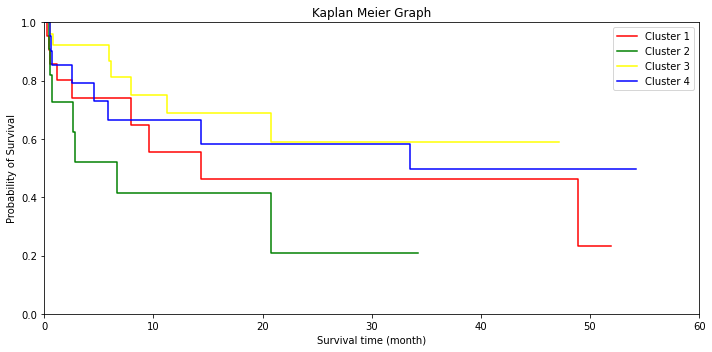

In [41]:
Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = ["red" , "green" , "yellow" , "blue", "violet" , "Indigo" , "Orange" , "grey" , "white" , "pink"] , Clinical_data = Clinical_data)

In [42]:
Results = LogRankTest_PrintValues(labels , Clinical_data_new, printResults=False)

In [43]:
labels_count = len(np.unique(labels))
pvalue_list =   [ [] for _ in range(labels_count) ]
min_pvalues = [ ]

for i in range(labels_count):
    for j in range(labels_count):
        if i == j:
            pass
        else:
            pvalue_list[i].append(round(Results[i][j].p_value,2))

for i in range(labels_count):
    min_pvalues.append(np.min(pvalue_list[i]))

SignCluster = [ ]
for i in range(len(min_pvalues)):
    if min_pvalues[i] == np.min(min_pvalues):
        SignCluster.append(i)

pvalue = np.min(min_pvalues)
print(SignCluster)


print("Significant Clusters are: Cluster " + str(SignCluster[0]+1) + " and Cluster " + str(SignCluster[1]+1))

[1, 2]
Significant Clusters are: Cluster 2 and Cluster 3


Text(0.3, 0.05, 'P-value= 0.02')

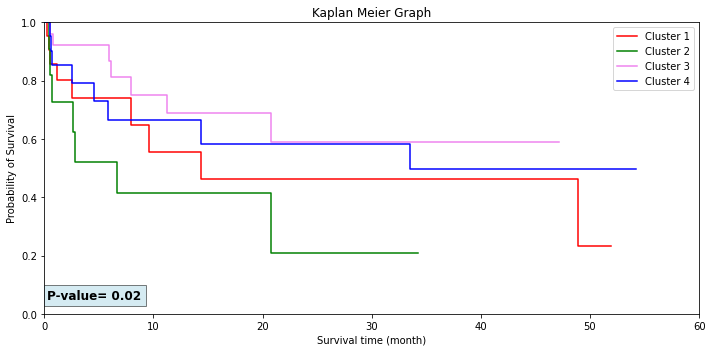

In [44]:
Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = ["red" , "green" , "violet" , "blue"] , Clinical_data = Clinical_data)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))

Text(0.3, 0.05, 'P-value= 0.02')

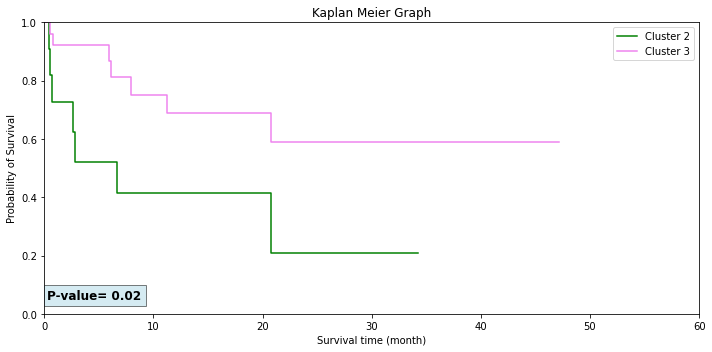

In [45]:
Clinical_data_new= KaplanMeierSurvivalFitter(labels , colors = ["red" , "green" , "violet", "blue"] , Clinical_data = Clinical_data,SignCluster=SignCluster)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))

## Section 7 - Cox Hazard Ratio

<lifelines.CoxPHFitter: fitted with 63 total observations, 40 right-censored observations>
             duration col = 'Surv_time'
                event col = 'Surv_status'
      baseline estimation = breslow
   number of observations = 63
number of events observed = 23
   partial log-likelihood = -60.10
         time fit was run = 2022-03-26 16:29:59 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Dead in Cluster 1   1.55       4.73       0.52             0.53             2.58                 1.70                13.17
Dead in Cluster 2   2.04       7.69       0.59             0.89             3.19                 2.44                24.21
Dead in Cluster 3   1.29       3.62       0.59             0.14             2.44                 1.15                11.42
Dead in Cluster 4   1.80       6.04       0.55             0.72             2.88                 2.06                17.75

                     z      p   -log2(p)
covariate                               
Dead in Cluster 1 2.97 <0.005       8.39
Dead in Cluster 2 3.48 <0.005      10.98
Dead in Cluster 3 2.20   0.03       5.15
Dead in Cluster 4 3.27 <0.005       9.88
---
Concordance = 0.87
Partial AIC = 128.21
log-likelihood ratio test = 38.58 on 4 df
-log2(p) of ll-ratio test = 23.48

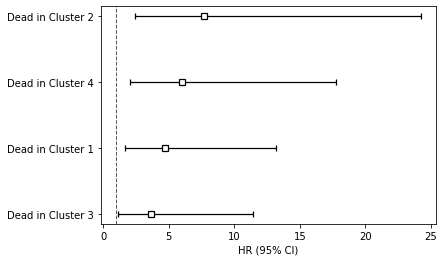

In [46]:
cph = CoxHazardFitter(labels , Clinical_data = Clinical_data_new)

In [47]:
labels_count = len(np.unique(labels))

Clusters = [ [] for _ in range(labels_count)]
for cluster_label in range(labels_count):
    Clusters[cluster_label] = Clinical_data_new.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")

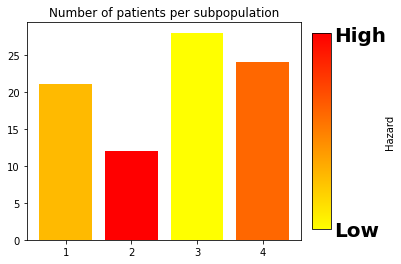

<Figure size 432x288 with 0 Axes>

In [48]:
COLORS = ["yellow" , "red"]
CoxHazardBarPlot(cph = cph, colors = COLORS , clusters = Clusters)


## Section 8 - SAM

In [49]:
# Detect the hazardcous cluster
hazardous_cluster_label = np.argmax(cph.hazard_ratios_) # Find the max hazard ratio's index and that will be the hazardous cluster label


print("Hazardous cluster label's index is {} and it is cluster {}".format(hazardous_cluster_label,hazardous_cluster_label+1))

Hazardous cluster label's index is 1 and it is cluster 2


In [50]:
labels= kmeans_4.labels_
labels_count=len(np.unique(kmeans_4.labels_))
indices_of_patients = [[] for _ in range(len(Clinical_data))]
Sig_Cluster=[[] for _ in range(len(Clinical_data))]
Status=[[] for _ in range(len(Clinical_data))]

for i in range(1,len(Clinical_data)+1):
    Pixels_Samples = np.where(sample_ID_pixels == i)[0]
    Patient_Labels = labels[Pixels_Samples]
    
    for cluster_label in range(labels_count):

        Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]

        if len(Patient_Pixels) >= int((1/labels_count * len(Patient_Labels))):

            if cluster_label != hazardous_cluster_label: # Hazardous cluster
                Status[i-1].append(1)
            else:
                Status[i-1].append(2)  


            Sig_Cluster[i-1].append(cluster_label)

    for j in range(0,len(Sig_Cluster[i-1])):
        
        indices=np.where(labels == Sig_Cluster[i-1][j])[0]

        # for element in indices:
        #     if element in Pixels_Samples:
                
        #         indices_of_patients[i-1].append(element)

        indices_of_patients[i-1].extend(list(set(Pixels_Samples).intersection(indices)))


In [51]:
Final_Status=[]
for patient in Status:
    if 1 in patient:
        Final_Status.append(2)
    else:
        Final_Status.append(1)

In [52]:
Unique_IDs = list(range(1,len(Clinical_data)+1))
Metastasis_Patients = [ ]
Average_protein_values = [ ]

for i in range(0,len(Unique_IDs)):
    Patient_MSI_values = sample_only_data[indices_of_patients[i]]
    Metastasis_Patients.append(Patient_MSI_values)
    Average_protein_values.append(np.average(Metastasis_Patients[i], axis=0))

In [53]:
protein_dataframe = pd.DataFrame(Average_protein_values,columns=peak_list[:,0].astype(int))
protein_dataframe["Status"] = Final_Status
# protein_dataframe["SampleID"] = np.arange(1,len(Clinical_data)+1)

In [54]:
protein_dataframe

,2757,3006,3196,3330,3374,3409,3445,3482,3516,3598,...,13915,14021,14708,15144,15346,15888,21326,21830,22550,Status
0,0.001437,0.001519,0.001131,0.005403,0.020950,0.014720,0.029787,0.038671,0.011458,0.002376,...,0.005098,0.010269,0.000515,0.000437,0.001189,0.000303,0.000732,0.001012,0.000610,1
1,0.000893,0.000917,0.000979,0.001547,0.000686,0.000967,0.002286,0.002162,0.001515,0.000780,...,0.005371,0.014260,0.000223,0.006652,0.003364,0.001266,0.000682,0.000859,0.001088,2
2,0.001369,0.001637,0.001481,0.006964,0.028801,0.020626,0.041338,0.052492,0.015115,0.003176,...,0.000831,0.001519,0.000491,0.000328,0.000453,0.000325,0.000330,0.000343,0.000341,1
3,0.002371,0.002831,0.002135,0.001621,0.001720,0.002309,0.003196,0.003224,0.002856,0.001893,...,0.004781,0.009670,0.002048,0.003188,0.002545,0.000710,0.000533,0.000967,0.000632,2
4,0.001357,0.002308,0.002048,0.005463,0.001601,0.001859,0.002689,0.002566,0.001837,0.001202,...,0.010560,0.015440,0.002670,0.001898,0.001691,0.000599,0.000653,0.000706,0.000896,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.002397,0.002091,0.002316,0.007115,0.021789,0.014608,0.031201,0.016303,0.008646,0.002337,...,0.002872,0.004750,0.000923,0.001304,0.001465,0.000541,0.000460,0.000542,0.000542,2
59,0.001261,0.000974,0.000990,0.002818,0.008198,0.003090,0.012574,0.015267,0.001782,0.001170,...,0.011075,0.023639,0.001570,0.002767,0.003281,0.000827,0.000456,0.001058,0.000846,2
60,0.002478,0.004361,0.001429,0.003607,0.022411,0.010210,0.041712,0.020490,0.006073,0.001700,...,0.001578,0.003420,0.000975,0.000339,0.000517,0.000390,0.000607,0.000798,0.001059,1
61,0.001971,0.003525,0.001482,0.002587,0.008380,0.004646,0.013327,0.008061,0.003297,0.001417,...,0.007218,0.015995,0.000479,0.000520,0.001436,0.000456,0.001296,0.001309,0.001270,2


In [55]:
protein_dataframe.to_csv("GastricCancerAverageSpectrumValues.csv",index=False)

In [56]:
protein_ion = 3670
protein_index = protein_dataframe.columns.get_loc(protein_ion)
print(protein_index)

10


In [57]:
scaler = MinMaxScaler(feature_range=(-1,1))

Scaled_MSI_Protein_Values = scaler.fit_transform(MSI_data_cube[:,:,protein_index]) 

In [58]:
# np.unique(MSI_data_cube[:,:,protein_index])[1]
protein_arr = copy.deepcopy(MSI_data_cube[:,:,protein_index])
#protein_arr = copy.deepcopy(Scaled_MSI_Protein_Values)

mask = (MSI_data_cube[:,:,protein_index] == 0)
#mask = (Scaled_MSI_Protein_Values == -1) 

protein_arr[mask]= 0

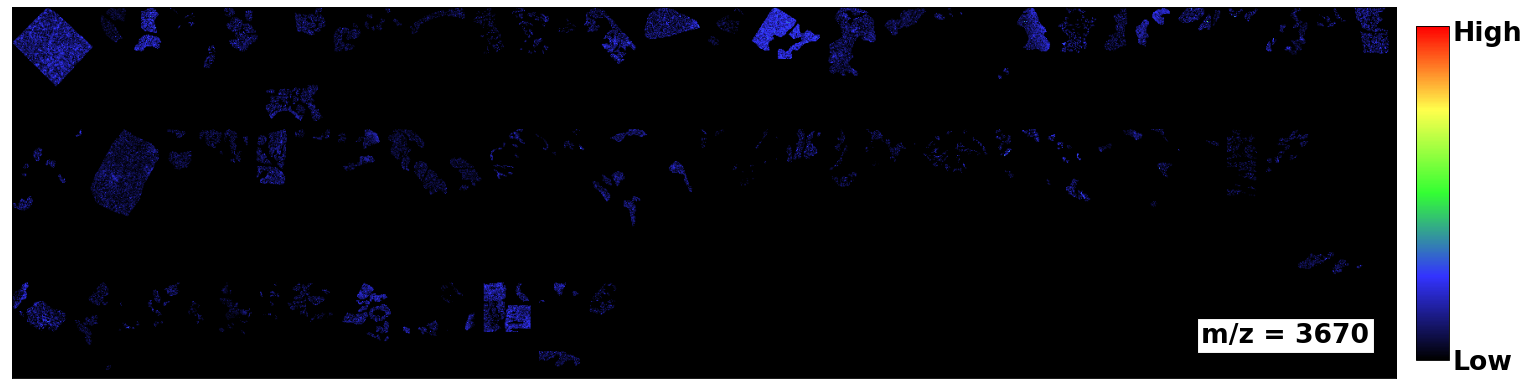

In [59]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


colorarray=["black",adjust_lightness("blue",1.2),adjust_lightness("lime",1.2),adjust_lightness("yellow",1.3),adjust_lightness("red",1)]
cmap = CreateColorMap_Continuous(len(colorarray)+1,colorarray)

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.imshow(protein_arr,cmap)
colorbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)
max_tick = 0.025 # variable to be edited for max tick

colorbar.ax.tick_params(size=0)
colorbar.set_ticks([0,max_tick]) # Comment the colorbar lines and look at the tick values to find the max value tick to be edited
colorbar.ax.set_yticklabels(['Low','High'],weight='bold',fontsize=24) 
plt.text(1420,400, "{}{}".format("m/z = ", protein_ion) , fontsize = 24,fontweight="bold",bbox = dict(facecolor = 'white', alpha = 1))
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()


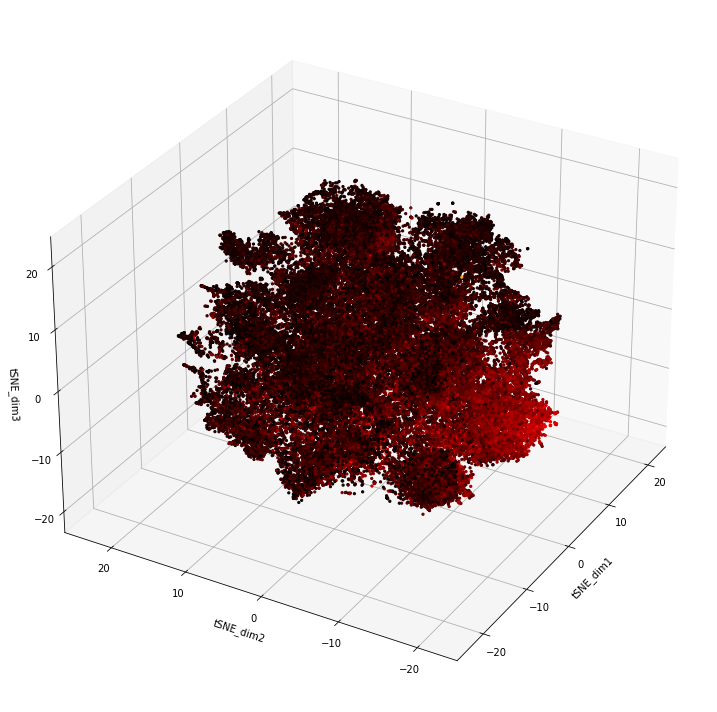

In [60]:
cmhot = plt.get_cmap("hot") #name of cmap u want from matplotlib

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = sample_only_data[:,protein_index],
    cmap = cmhot,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

## Classifier 


In [61]:
SAM_Protein=[3409,3445,3374,3711,3482,3670,3516,13166,3598,10843]

In [62]:
SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_Protein:
        SAM_protein_indices.append(i)

In [63]:
##### Whole data testing

labels=kmeans_4.labels_
labels_count = len(np.unique(labels))
Clusters = [ [] for _ in range(labels_count) ]
Target_labels=copy.deepcopy(labels)
Poor_survival_cluster=1
High_survival_cluster=2
Poor = 1
Moderate = 2
High = 3

dropped_patient= -1
for i in range(1,len(Clinical_data)+1):
    if i == dropped_patient:
        break
    Pixels_Samples = np.where(sample_ID_pixels == i)[0]
    Patient_Labels = labels[Pixels_Samples]

    for cluster_label in range(labels_count):
        Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]
        if len(Patient_Pixels) >= int( (1/labels_count * len(Patient_Labels))):
            Clusters[cluster_label].append(i)

for i in Clusters[Poor_survival_cluster]:
    Pixels_Samples = np.where(sample_ID_pixels == i)[0]
    Target_labels[Pixels_Samples] = Poor

Target_labels[Target_labels != Poor] = Moderate

for i in Clusters[High_survival_cluster]:
    Pixels_Samples = np.where(sample_ID_pixels == i)[0]
    Target_labels[Pixels_Samples] = High


In [64]:
test_patient_indicies=np.where(sample_ID_pixels == 4)

mask = np.ones(sample_only_scaled_data.shape[0], dtype=bool)
mask[test_patient_indicies] = False

train_data= sample_only_scaled_data[mask]
test_data= sample_only_scaled_data[test_patient_indicies]

train_labels=Target_labels[mask]
test_labels=Target_labels[test_patient_indicies]


train_data= train_data[:,SAM_protein_indices]
test_data= test_data[:,SAM_protein_indices]

In [65]:
# SVM Model

from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_data, train_labels)

#Predict the response for test dataset
y_pred = clf.predict(test_data)

In [74]:
Propability_arr=np.unique(y_pred,return_counts=True)

In [79]:
Total_Propability= sum(Propability_arr[1])
Poor_Surv= (Propability_arr[1][0] /Total_Propability ) * 100
Moderate_Surv= (Propability_arr[1][1] / Total_Propability ) * 100
High_Surv= (Propability_arr[1][2] / Total_Propability ) * 100

In [80]:
Poor_Surv

0.4444444444444444

In [82]:
Moderate_Surv

44.0

In [83]:
High_Surv

55.55555555555556

In [66]:
## KNN Model
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
model.fit(train_data,train_labels)

KNeighborsClassifier()

In [67]:
predicted_labels= model.predict(test_data)

In [68]:
Propability_arr=np.unique(predicted_labels,return_counts=True)

In [69]:
Total_Propability= sum(Propability_arr[1])
Poor_Surv= (Propability_arr[1][0] /Total_Propability ) * 100
Moderate_Surv= (Propability_arr[1][1] / Total_Propability ) * 100
High_Surv= (Propability_arr[1][2] / Total_Propability ) * 100

In [70]:
Poor_Surv

1.3333333333333335

In [71]:
Moderate_Surv

41.333333333333336

In [72]:
High_Surv

57.333333333333336